This file is ran on colab

Unzipping Data

In [1]:
!jar xvf /content/origin_health_role_challenge_dataset.zip
# removing unlabled image and a corresponding label with no image
!rm /content/interview/train/images/230_2HC.png
!rm /content/interview/train/labels/231_HC_Annotation.png

  created: interview/
  created: interview/test/
  created: interview/test/images/
 inflated: interview/test/images/592_2HC.png
 inflated: interview/test/images/512_HC.png
 inflated: interview/test/images/198_HC.png
 inflated: interview/test/images/220_HC.png
 inflated: interview/test/images/567_HC.png
 inflated: interview/test/images/407_HC.png
 inflated: interview/test/images/230_2HC.png
 inflated: interview/test/images/516_HC.png
 inflated: interview/test/images/197_HC.png
 inflated: interview/test/images/693_HC.png
 inflated: interview/test/images/532_2HC.png
 inflated: interview/test/images/328_HC.png
 inflated: interview/test/images/333_HC.png
  created: interview/train/
  created: interview/train/images/
 inflated: interview/train/images/307_HC.png
 inflated: interview/train/images/325_HC.png
 inflated: interview/train/images/693_HC.png
 inflated: interview/train/images/461_HC.png
 inflated: interview/train/images/464_HC.png
 inflated: interview/train/images/591_HC.png
 inflated

In [1]:
!pip install -U segmentation-models #for colab

In [1]:
import torch
import glob
import os
from PIL import Image
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.preprocessing import normalize
import keras
from tensorflow.keras.utils import normalize, to_categorical
from sklearn.preprocessing import LabelEncoder
import segmentation_models as sm
from torch.utils.data import DataLoader
import albumentations as album

Segmentation Models: using `keras` framework.


Dataloader

In [2]:
import torch.utils.data as data

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, test = False):
        '''
        folder path: Root folder which contains the images folder and labels folder
        test: if root folder doesn't contain labels folder, give True

        root

        |_images
                |_ .png 

                |_ ...
        |_labels
                |_ _Annotation.png
                
                |_ ...

        '''

        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path,'images','*.png'))
        self.mask_files = []
        self.img = []
        self.mask = []
        self.test = test
        
        if not self.test:
            for img_path in self.img_files: # Making sure that the corresponding mask exists for a particular image
                self.mask_files.append(os.path.join(folder_path,'labels',os.path.basename(img_path.split(".")[0] + "_Annotation.png"))) 
        
    def __getall__(self):
        for each in self.img_files:
            self.img.append(normalize(cv2.resize(cv2.imread(each, cv2.IMREAD_COLOR), (512,512)), axis = 1)) # Reading images as RGB
        if not self.test:
            for each in self.mask_files:
                self.mask.append(cv2.resize(cv2.imread(each, 0), (512,512))) #Reading masks as grayscale
            return (np.array(self.img)) , (np.array(self.mask)) #returning images and its corresponding mask
        else:
            return (np.array(self.img)) #returning images

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_COLOR) # Reading images as RGB
            data = cv2.resize(data, (512, 512)) # resizing to 512x512
            label = cv2.imread(mask_path, 0) #Reading masks as grayscale
            label = cv2.resize(label, (512, 512)) # resizing to 512x512

            return np.array(data), np.array(label)

    def __len__(self):
        return len(self.img_files)

In [ ]:
path_to_train = "/content/interview/train"
path_to_val = "/content/interview/val"
path_to_test = "/content/interview/test"

In [5]:
train_dataset = DataLoaderSegmentation(path_to_train)
val_dataset = DataLoaderSegmentation(path_to_val)
test_dataset = DataLoaderSegmentation(path_to_test, test = True)

(512, 512, 3) (512, 512)


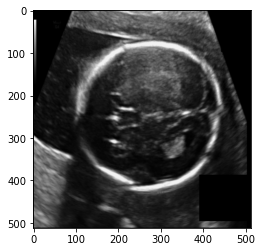

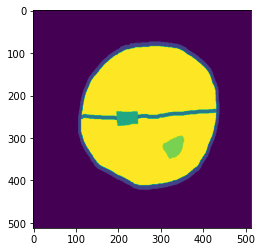

In [6]:
image, mask = train_dataset.__getitem__(5)
print(image.shape, mask.shape)
plt.imshow(image/255)
plt.show()
plt.imshow(mask/255)
plt.show()

Loading and Setting up data for training

In [27]:
train_images, train_masks = train_dataset.__getall__()
val_images, val_masks = val_dataset.__getall__()
test_images = test_dataset.__getall__()

In [28]:
print(train_images.shape, train_masks.shape)
print(val_images.shape, val_masks.shape)
print(test_images.shape)

(59, 512, 512, 3) (59, 512, 512)
(10, 512, 512, 3) (10, 512, 512)
(13, 512, 512, 3)


In [29]:
print(np.unique(train_masks)) #No. of classes

[0 1 2 3 4 5]


For computing class weights to handle class imbalance

In [30]:
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_masks_reshaped_encoded),
                                        y = train_masks_reshaped_encoded                                                    
                                    )
class_weights_dict ={}
for i, each in enumerate(class_weights):
  class_weights_dict[i] = each
print("Class weights are...:", class_weights)
print(class_weights_dict)

Class weights are...: [ 0.27363086  3.49018015 19.8645973  28.50893433 16.00420529  0.52328018]
{0: 0.27363085639005397, 1: 3.4901801494415348, 2: 19.864597300782435, 3: 28.508934331648586, 4: 16.004205289310246, 5: 0.5232801801114166}


Making mask images to categorical mask images

In [32]:
train_masks_cat = (to_categorical(train_masks, num_classes = 6))
val_masks_cat = (to_categorical(val_masks, num_classes = 6))
print(train_masks_cat.shape)
print(val_masks_cat.shape)

(59, 512, 512, 6)
(10, 512, 512, 6)


# Model

In [36]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model
 

# Unet Training Setup

In [37]:
import tensorflow as tf
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [38]:
IMG_HEIGHT = train_images.shape[1]
IMG_WIDTH  = train_images.shape[2]
IMG_CHANNELS = train_images.shape[3]
n_classes = 6

print(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)
dice_loss = sm.losses.DiceLoss(class_weights = class_weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics=metrics)
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')


512 512 3
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 512, 512, 16  0           ['conv2d_19[0][0]']              
                                )                                                 

In [39]:
from tensorflow.keras.callbacks import EarlyStopping
import datetime
custom_early_stopping = EarlyStopping(
    monitor='val_iou_score', 
    patience=15, 
    min_delta=0.001, 
    mode='max'
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Training

In [40]:
import pickle
history = model.fit(train_images, 
                    train_masks_cat, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=200, 
                    validation_data=(val_images, val_masks_cat),
                    callbacks = [custom_early_stopping, tensorboard_callback], 
                    shuffle=False)
model.save("unet_on_RGB_with_dice_and_focal_with_class_weights_batch_8_epoch_200_with_earlystoppin_and_tensorboard.hdf5")
with open('trainHistoryDict_unet_batch8_epoch300_earlystopping', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Epoch 1/200
8/8 [==============================] - 6s 520ms/step - loss: 0.8203 - iou_score: 3.9051e-10 - f1-score: 3.9051e-10 - val_loss: 0.8240 - val_iou_score: 8.7374e-10 - val_f1-score: 8.7374e-10
Epoch 2/200
8/8 [==============================] - 4s 451ms/step - loss: 0.8175 - iou_score: 2.6046e-07 - f1-score: 5.2053e-07 - val_loss: 0.8210 - val_iou_score: 8.7374e-10 - val_f1-score: 8.7374e-10
Epoch 3/200
8/8 [==============================] - 3s 438ms/step - loss: 0.8122 - iou_score: 3.7996e-05 - f1-score: 7.5965e-05 - val_loss: 0.8156 - val_iou_score: 8.7374e-10 - val_f1-score: 8.7374e-10
Epoch 4/200
8/8 [==============================] - 3s 436ms/step - loss: 0.7914 - iou_score: 0.0120 - f1-score: 0.0216 - val_loss: 0.7864 - val_iou_score: 0.0058 - val_f1-score: 0.0111
Epoch 5/200
8/8 [==============================] - 3s 437ms/step - loss: 0.7288 - iou_score: 0.0525 - f1-score: 0.0859 - val_loss: 0.7220 - val_iou_score: 0.0401 - val_f1-score: 0.0698
Epoch 6/200
8/8 [==========

Metrics

In [43]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels # taking average

In [44]:
# IOU metric
import keras.backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

For A and B 0.6608711317442854


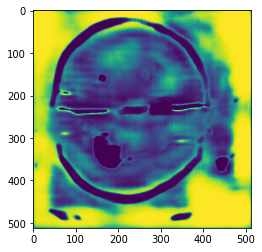

In [45]:
y_pred=model.predict(val_images)
plt.imshow(y_pred[0,:,:,0])
dice_score = dice_coef_multilabel(val_masks_cat, y_pred, 6)
print(f'For A and B {dice_score}')

In [46]:
y_pred=model.predict(val_images)
iou = iou_coef(val_masks_cat, y_pred)
print(f'For A and B {iou}')

For A and B 0.5924585461616516


# Other varirants of Unet

### Resnet

Setup

In [49]:
n_classes=6
activation='softmax'

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights = class_weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [45]:
sm.set_framework('tf.keras')
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(train_images)
X_val = preprocess_input1(val_images)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())


85532672/85521592 [==============================] - 4s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

Training

In [46]:
history1=model1.fit(X_train1, 
          train_masks_cat,
          batch_size=4, 
          epochs=50,
          verbose=1,
          validation_data=(X_val, val_masks_cat))
model1.save("unet_with_resnet_backbone_with_dice_and_focal_batch_4.hdf5")

Epoch 1/50
15/15 [==============================] - 20s 647ms/step - loss: 0.7525 - iou_score: 0.0177 - f1-score: 0.0336 - val_loss: 0.9284 - val_iou_score: 0.0040 - val_f1-score: 0.0078
Epoch 2/50
15/15 [==============================] - 5s 322ms/step - loss: 0.4506 - iou_score: 0.0791 - f1-score: 0.1378 - val_loss: 0.9371 - val_iou_score: 0.0030 - val_f1-score: 0.0058
Epoch 3/50
15/15 [==============================] - 5s 318ms/step - loss: 0.0951 - iou_score: 0.1248 - f1-score: 0.2034 - val_loss: 0.8452 - val_iou_score: 8.8658e-05 - val_f1-score: 1.7713e-04
Epoch 4/50
15/15 [==============================] - 5s 320ms/step - loss: -0.1288 - iou_score: 0.1603 - f1-score: 0.2446 - val_loss: 0.8387 - val_iou_score: 1.5044e-04 - val_f1-score: 3.0046e-04
Epoch 5/50
15/15 [==============================] - 5s 316ms/step - loss: -0.3812 - iou_score: 0.1830 - f1-score: 0.2726 - val_loss: 0.8030 - val_iou_score: 9.2054e-10 - val_f1-score: 9.2054e-10
Epoch 6/50
15/15 [=========================

Metrics

In [ ]:
y_pred=model1.predict(val_images)
plt.imshow(y_pred[0,:,:,0])
dice_score = dice_coef_multilabel(val_masks_cat, y_pred, 6)
print(f'For A and B {dice_score}')

In [ ]:
y_pred=model1.predict(val_images)
iou = iou_coef(val_masks_cat, y_pred)
print(f'For A and B {iou}')

### InceptionV3

Setup

In [51]:
sm.set_framework('tf.keras')
BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(train_images)
X_test2 = preprocess_input2(val_images)

# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)


# compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics)
#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model2.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_132 (Conv2D)            (None, None, None,   864         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_132[0][0]']             
 ormalization)                  32)                                                         

Training

In [52]:
history2=model2.fit(X_train2, 
          train_masks_cat,
          batch_size=4, 
          epochs=50,
          verbose=1,
          validation_data=(X_test2, val_masks_cat))
model.save("unet_with_inception_backbone_with_dice_and_focal_batch_4.hdf5")

Epoch 1/50
15/15 [==============================] - 28s 1s/step - loss: 0.6911 - iou_score: 0.0224 - f1-score: 0.0407 - val_loss: 0.6655 - val_iou_score: 0.0589 - val_f1-score: 0.0994
Epoch 2/50
15/15 [==============================] - 6s 419ms/step - loss: 0.3157 - iou_score: 0.1103 - f1-score: 0.1753 - val_loss: 0.6674 - val_iou_score: 0.1205 - val_f1-score: 0.1398
Epoch 3/50
15/15 [==============================] - 6s 417ms/step - loss: -0.0504 - iou_score: 0.1801 - f1-score: 0.2740 - val_loss: 0.6596 - val_iou_score: 0.1203 - val_f1-score: 0.1397
Epoch 4/50
15/15 [==============================] - 6s 412ms/step - loss: -0.3519 - iou_score: 0.1994 - f1-score: 0.3024 - val_loss: 0.7076 - val_iou_score: 0.1040 - val_f1-score: 0.1280
Epoch 5/50
15/15 [==============================] - 6s 407ms/step - loss: -0.6043 - iou_score: 0.2087 - f1-score: 0.3127 - val_loss: 0.5409 - val_iou_score: 0.0992 - val_f1-score: 0.1314
Epoch 6/50
15/15 [==============================] - 6s 405ms/step - l

Metrics

For A and B 0.17437292854302924


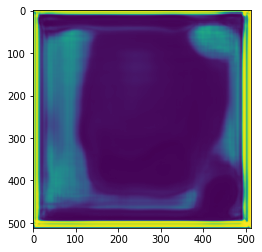

In [53]:
y_pred=model2.predict(val_images)
plt.imshow(y_pred[0,:,:,0])
dice_score = dice_coef_multilabel(val_masks_cat, y_pred, 6)
print(f'For A and B {dice_score}')

In [54]:
y_pred=model2.predict(val_images)
iou = iou_coef(val_masks_cat, y_pred)
print(f'For A and B {iou}')

For A and B 0.3251286745071411


### VGG16

Setup

In [52]:
sm.set_framework('tf.keras')
BACKBONE3 = 'vgg16'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train3 = preprocess_input3(train_images)
X_test3 = preprocess_input3(val_images)


# define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model3.compile(optim, total_loss, metrics)
print(model3.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_4[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                         

Training

In [53]:
history3=model3.fit(X_train3, 
          train_masks_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test3, val_masks_cat))


model3.save('unet_with_vgg16_backbone_with_dice_and_focal_batch_8.hdf5')

Epoch 1/50
8/8 [==============================] - 40s 3s/step - loss: 0.8227 - iou_score: 0.0070 - f1-score: 0.0133 - val_loss: 0.8802 - val_iou_score: 0.0957 - val_f1-score: 0.1216
Epoch 2/50
8/8 [==============================] - 8s 968ms/step - loss: 0.8112 - iou_score: 0.0131 - f1-score: 0.0243 - val_loss: 0.9500 - val_iou_score: 0.0989 - val_f1-score: 0.1242
Epoch 3/50
8/8 [==============================] - 8s 961ms/step - loss: 0.8038 - iou_score: 0.0167 - f1-score: 0.0303 - val_loss: 0.9962 - val_iou_score: 0.1008 - val_f1-score: 0.1256
Epoch 4/50
8/8 [==============================] - 8s 961ms/step - loss: 0.7980 - iou_score: 0.0201 - f1-score: 0.0359 - val_loss: 1.0535 - val_iou_score: 0.1009 - val_f1-score: 0.1257
Epoch 5/50
8/8 [==============================] - 8s 992ms/step - loss: 0.7937 - iou_score: 0.0216 - f1-score: 0.0383 - val_loss: 1.0196 - val_iou_score: 0.1012 - val_f1-score: 0.1259
Epoch 6/50
8/8 [==============================] - 8s 972ms/step - loss: 0.7896 - i

Metrics

In [ ]:
y_pred=model3.predict(val_images)
plt.imshow(y_pred[0,:,:,0])
dice_score = dice_coef_multilabel(val_masks_cat, y_pred, 6)
print(f'For A and B {dice_score}')

In [ ]:
y_pred=model3.predict(val_images)
iou = iou_coef(val_masks_cat, y_pred)
print(f'For A and B {iou}')